**Importing some important libraries**

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Lets consider the green data for January 2018**

In [180]:
#df = pd.read_csv('yellow_tripdata_2018-01.csv')
df = pd.read_csv('green_tripdata_2018-01.csv')

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793529 entries, 0 to 793528
Data columns (total 19 columns):
VendorID                 793529 non-null int64
lpep_pickup_datetime     793529 non-null object
lpep_dropoff_datetime    793529 non-null object
store_and_fwd_flag       793529 non-null object
RatecodeID               793529 non-null int64
PULocationID             793529 non-null int64
DOLocationID             793529 non-null int64
passenger_count          793529 non-null int64
trip_distance            793529 non-null float64
fare_amount              793529 non-null float64
extra                    793529 non-null float64
mta_tax                  793529 non-null float64
tip_amount               793529 non-null float64
tolls_amount             793529 non-null float64
ehail_fee                0 non-null float64
improvement_surcharge    793529 non-null float64
total_amount             793529 non-null float64
payment_type             793529 non-null int64
trip_type                79

Looks like `ehail_fee` is useless column, its 0 all the time, lets drop it at the moment!

In [182]:
df.drop('ehail_fee', inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793529 entries, 0 to 793528
Data columns (total 18 columns):
VendorID                 793529 non-null int64
lpep_pickup_datetime     793529 non-null object
lpep_dropoff_datetime    793529 non-null object
store_and_fwd_flag       793529 non-null object
RatecodeID               793529 non-null int64
PULocationID             793529 non-null int64
DOLocationID             793529 non-null int64
passenger_count          793529 non-null int64
trip_distance            793529 non-null float64
fare_amount              793529 non-null float64
extra                    793529 non-null float64
mta_tax                  793529 non-null float64
tip_amount               793529 non-null float64
tolls_amount             793529 non-null float64
improvement_surcharge    793529 non-null float64
total_amount             793529 non-null float64
payment_type             793529 non-null int64
trip_type                793526 non-null float64
dtypes: float64(9), in

Let's have a quick look on the `store_and_fwd_flag` column

In [183]:
df.store_and_fwd_flag.unique(), df.store_and_fwd_flag.value_counts()

(array(['N', 'Y'], dtype=object), N    792170
 Y      1359
 Name: store_and_fwd_flag, dtype: int64)

`store_and_fwd_flag` is either the customer was dispatched or a flag.<br>
Let's convert this to `1/0 ==> N = 1, Y = 0` with new column name `dispatch`. **Notice that dispatch is common type of trip**<br>
Another thing we can see, which day the flag is more than dispatch, probability if higher for the flag is on weekends nights!<br>
Let's write a custom function to convert the categorical col to 1/0

In [184]:
def cat_to_num(x):
    if x.lower() == 'n':
        return 1
    if x.lower() == 'y':
        return 0

In [185]:
df['dispatch'] = df['store_and_fwd_flag'].apply(cat_to_num)

In [186]:
df.dispatch.value_counts()

1    792170
0      1359
Name: dispatch, dtype: int64

We can drop `store_and_fwd_flag`, we don't need it anymore after `dispatch` column.

In [189]:
df.drop('store_and_fwd_flag', inplace=True, axis=1)

I don't know what is VendorID! **However**, we can consider two dispatch companies, this could be another feature and suggest the preferred company to call for a cab. 

In [190]:
df.VendorID.value_counts()

2    655835
1    137694
Name: VendorID, dtype: int64

In [191]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,dispatch
0,2,2018-01-01 00:18:50,2018-01-01 00:24:39,1,236,236,5,0.70,6.0,0.5,0.5,0.0,0.0,0.3,7.3,2,1.0,1
1,2,2018-01-01 00:30:26,2018-01-01 00:46:42,1,43,42,5,3.50,14.5,0.5,0.5,0.0,0.0,0.3,15.8,2,1.0,1
2,2,2018-01-01 00:07:25,2018-01-01 00:19:45,1,74,152,1,2.14,10.0,0.5,0.5,0.0,0.0,0.3,11.3,2,1.0,1
3,2,2018-01-01 00:32:40,2018-01-01 00:33:41,1,255,255,1,0.03,-3.0,-0.5,-0.5,0.0,0.0,-0.3,-4.3,3,1.0,1
4,2,2018-01-01 00:32:40,2018-01-01 00:33:41,1,255,255,1,0.03,3.0,0.5,0.5,0.0,0.0,0.3,4.3,2,1.0,1


**Dealing with `lpep_pickup_datetime & lpep_dropoff_datetime`** Columns<br>
* Separate dates and time from both columns.
* Some trips started in one date and end on the next date, we can avoid them to keep the things simple
* drop the original columns 

new columns will be <br>
* PUD -- PickUp Date
* PUT -- PickUp Time
* DOD -- DropOff Date
* DOT -- DropOff Time

In [192]:
df['PUD'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.date
df['PUT'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.time
df['DOD'] = pd.to_datetime(df['lpep_dropoff_datetime']).dt.date
df['DOT'] = pd.to_datetime(df['lpep_dropoff_datetime']).dt.time
df.drop(['lpep_pickup_datetime','lpep_dropoff_datetime'], axis = 1, inplace =True)

In [194]:
df = df[df['DOD'] == df['PUD']]

I think, now we don't need two dates now, we can create rename either (DOD or PUD) to data and delete the other!

In [198]:
df['date']=df['DOD']
df.drop(['DOD','PUD'], inplace = True, axis = 1)

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783769 entries, 0 to 793528
Data columns (total 19 columns):
VendorID                 783769 non-null int64
RatecodeID               783769 non-null int64
PULocationID             783769 non-null int64
DOLocationID             783769 non-null int64
passenger_count          783769 non-null int64
trip_distance            783769 non-null float64
fare_amount              783769 non-null float64
extra                    783769 non-null float64
mta_tax                  783769 non-null float64
tip_amount               783769 non-null float64
tolls_amount             783769 non-null float64
improvement_surcharge    783769 non-null float64
total_amount             783769 non-null float64
payment_type             783769 non-null int64
trip_type                783766 non-null float64
dispatch                 783769 non-null int64
PUT                      783769 non-null object
DOT                      783769 non-null object
date                   

**Comment please**<br>
We can create a column for a common hour  for pick-ups and drop-offs in some way (e.g. rounding the ride to the previous hour for some mins in the next hours say 15 mins). This way, we can make the data simple and count no of rides in each hour. A bar plot can tell us the busy hours that will schedule available resources (in this case no of cabs) on the respective time (we can add zone here as well). 

In [200]:
df.RatecodeID.value_counts()

1     768043
5      13692
2       1314
4        410
3        297
6         10
99         3
Name: RatecodeID, dtype: int64

**Comments please**<br>
Once again, there are 7 rate codes, it is clear that the regular code '1' is maximum rides. It is great if we can find this information from the website. We can use these codes as is for ML part but for EDA, its good to suggest which code is for what type of customer. If we could not find any info, we can self suggest the codes, no problem!

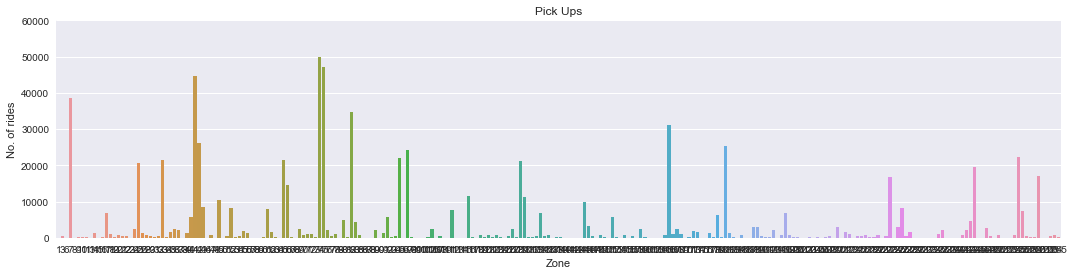

In [217]:
fig, ax = plt.subplots(figsize = (18,4))
sns.barplot(df.PULocationID.value_counts().index, df.PULocationID.value_counts().values, ax = ax)
ax.set_ylim(0,60000);
ax.set_ylabel('No. of rides')
ax.set_xlabel('Zone')
ax.set_title('Pick Ups')

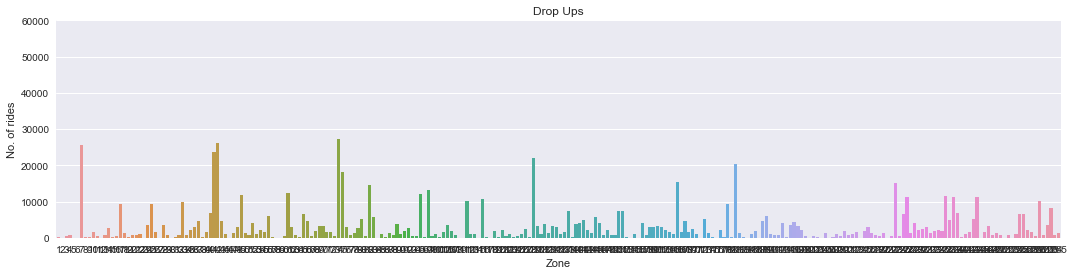

In [218]:
fig, ax = plt.subplots(figsize = (18,4))
sns.barplot(df.DOLocationID.value_counts().index, df.DOLocationID.value_counts().values, ax = ax)
ax.set_ylim(0,60000);
ax.set_ylabel('No. of rides')
ax.set_xlabel('Zone')
ax.set_title('Drop Ups')

The plots above may not look very good at the moment, however, they are suggesting the regions for the most calls. If we plot them w.r.t the time, we can see the flow of customer and get an idea of the commercial and residential zones. Remember, people living close to their offices have low probability to take cab.<br>
We may need to think about some kind of aggregation for these plots so that they look good. We can use custom pellet with selected colors to convey message.<br>
Another idea is to re-zone the city, which might not be a realistic thing because you never know how the zones are divided. Sometime, adjacent zones could have very different numbers, however this is not common in cab industry. <br>
We might be able to get a correlation for selected features in a heatmap....we can think about it.

In [222]:
df.to_csv('green_jan_2018_cleaned_1.csv', index=False)